In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import networkx as nx
import random
import numpy as np
import itertools
import scipy
from mpl_toolkits.mplot3d import axes3d

### Modified model

In [96]:
class Mod_SocialDynamicsSimulation:

    def __init__(self, network_size=70, alpha=0.06, beta=0.3, gamma=4, n_opinions = 5):
        
        '''
        alpha: how much nodes wil change their opinions
        beta: how easily weights will change
        gamma: how easily nodes break bonds with others with different opinions
        '''
        
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_opinions = n_opinions
        
    def initialize(self):
        self.graph = nx.barabasi_albert_graph(self.network_size, 2)
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinions'] = [random.randint(0, 1) for _ in range(self.n_opinions)]
            self.graph.nodes[node]['extrovert'] = random.uniform(0,1)      
            #influnece between 0 and 1, close to scale free (few people with influnece close to 1)
            self.graph.nodes[node]['influence']  = max(min(1, np.random.exponential(0.4)), 0.1)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5  
            #give a weight to each edge based on the extrover levels of it's nodes
            self.graph.edges[edge]['talk_weight'] =  sum([self.graph.nodes[n]['extrovert'] for n in edge])        
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels= False,
            #color nodes by mean opinion value
            #node_color=[np.mean(self.graph.nodes[i]['opinions']) for i in self.graph.nodes],
            #color nodes by extrovert level
            #node_color=[self.graph.nodes[i]['extrovert'] for i in self.graph.nodes],
            #color nodes by influence
            node_color=[self.graph.nodes[i]['influence'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            node_cmap = plt.cm.binary, node_vmin=0.1, node_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

   
    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            #include talk_weight based on nodes' level of extrovert
            talk_weight =  sum([self.graph.nodes[n]['extrovert'] for n in new_edge])
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5, talk_weight = talk_weight)
                               
        else:
            
            p_edges = list([self.graph.edges[i]['talk_weight'] for 
                                         i in list(self.graph.edges)])            
            p_edges  = [p / sum(p_edges) for p in p_edges]
                        
            # Select a random edge and update node opinions and edge weight
            edge_ind = np.random.choice([i for i in range(len(list(self.graph.edges)))], p = p_edges)           
            edge = list(self.graph.edges)[edge_ind]           
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinions'] for n in edge]
            influences = [self.graph.nodes[n]['influence'] for n in edge]
            
            #update each opinion
            for i in [0, 1]:
                for j in range(self.n_opinions):
                    self.graph.nodes[edge[i]]['opinions'][j] = (
                        opinions[i][j] + (self.alpha * weight * (opinions[1-i][j] - opinions[i][j])) * influences[i-1])
            
            #update weight based on the average difference in opinions
            
            avg_op_diff = max([abs(opinions[0][i] - opinions[1][i]) 
                               for i in range(self.n_opinions)]) 
            
            self.graph.edges[edge]['weight'] = (weight +self.beta * weight * (1-weight) *
                    (1 - self.gamma * avg_op_diff))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

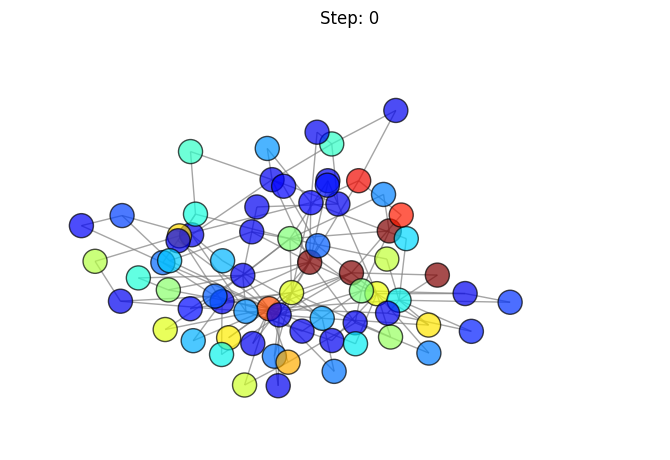

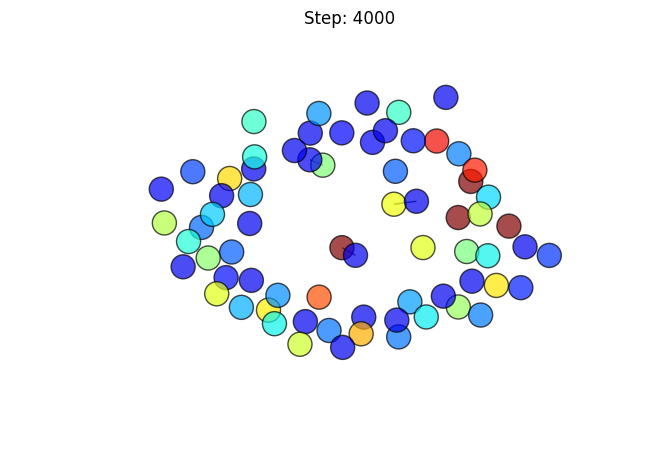

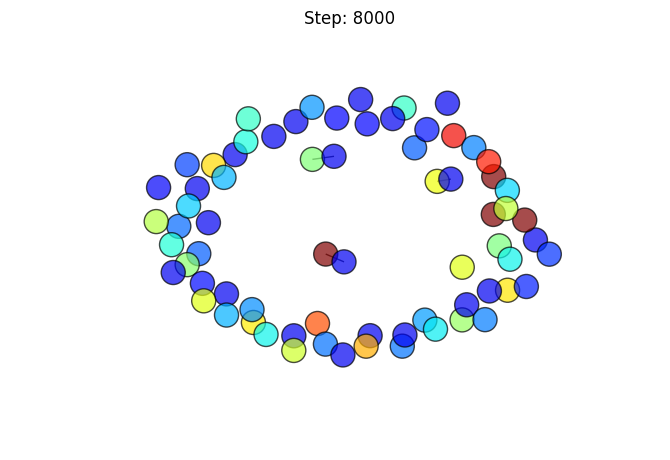

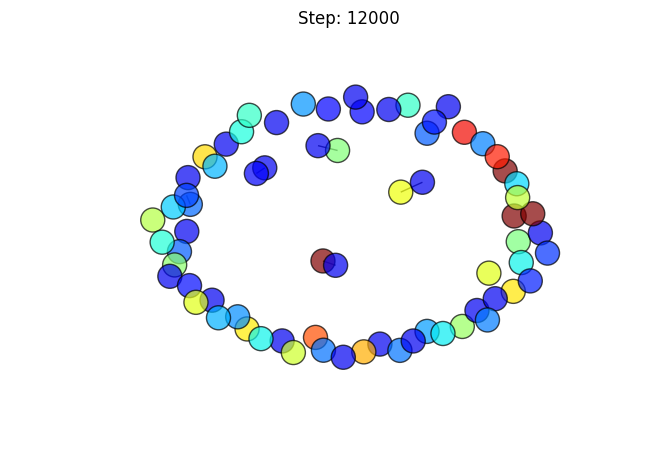

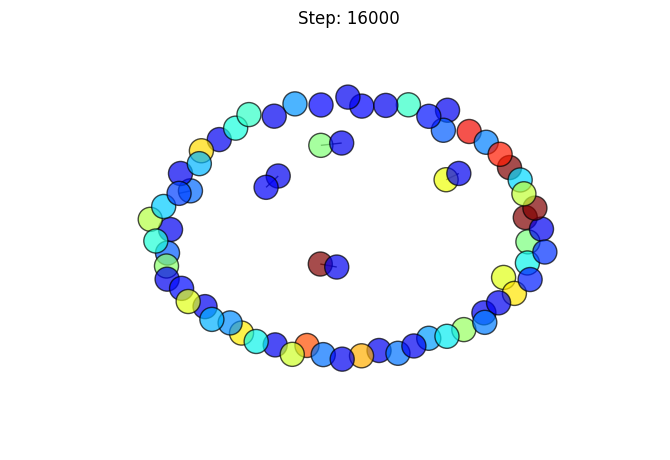

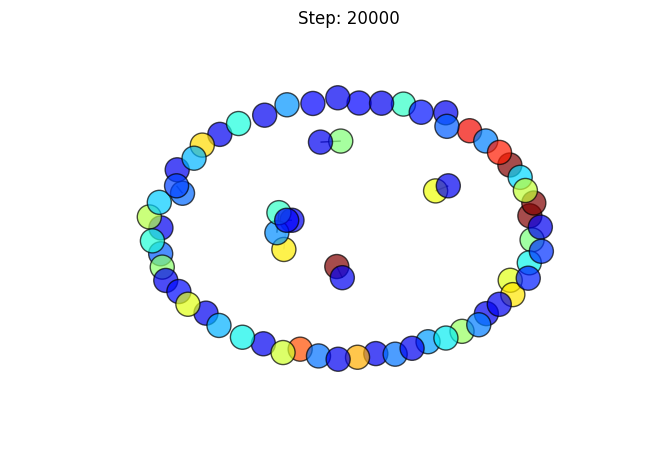

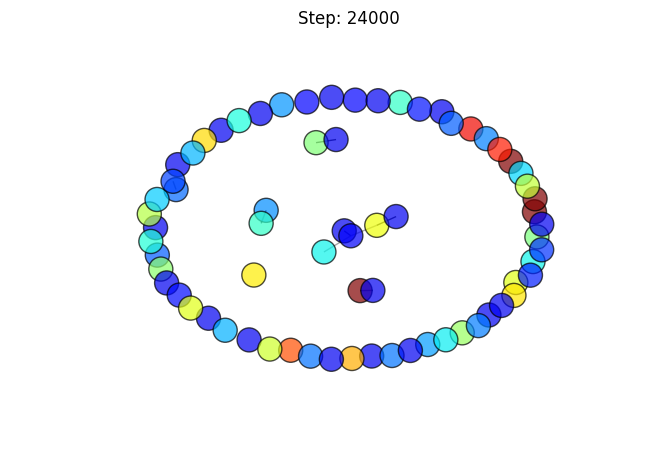

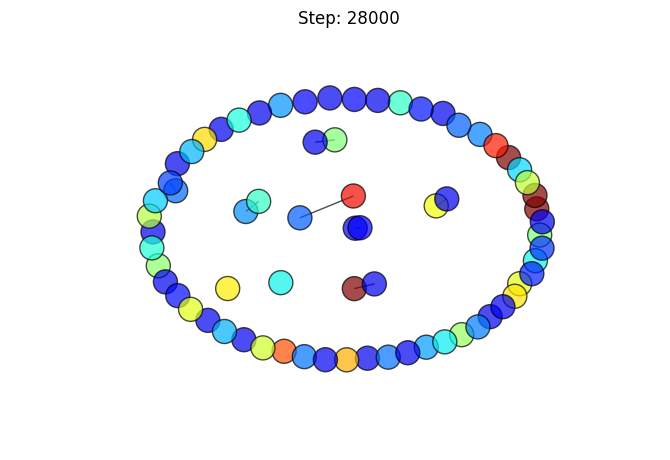

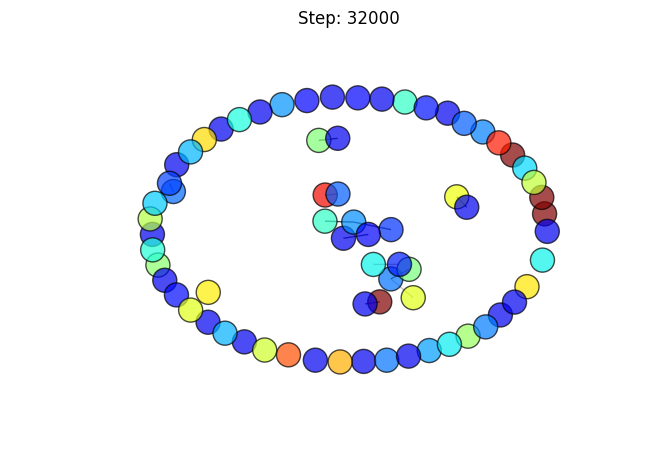

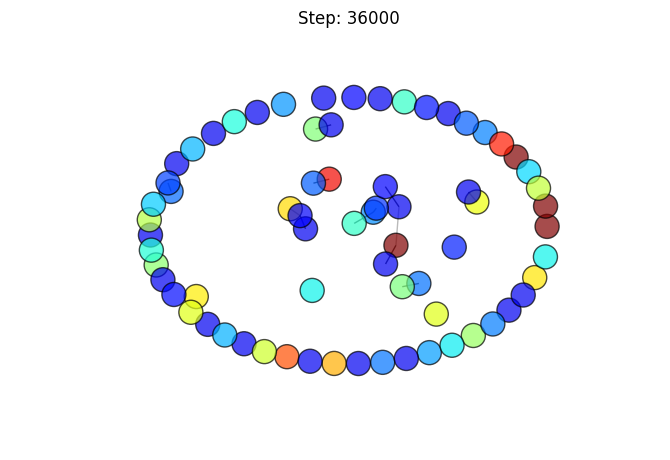

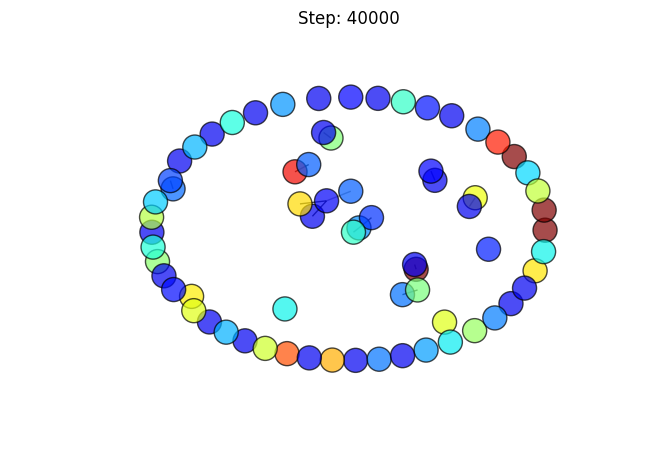

In [97]:
sim = Mod_SocialDynamicsSimulation()
sim.initialize()
sim.observe()
plt.figure()
for i in range(10):
    for i in range(4000):
        sim.update()
    sim.observe()
    plt.figure()

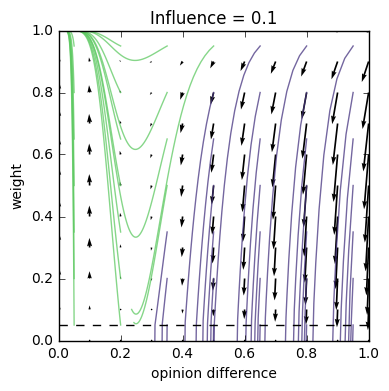

In [71]:
alpha = 0.15
beta = 0.3
gamma = 4
I =  0.1

cmap = plt.cm.viridis  # color map to use

# Plot traces of how opinion and weight change over timeh
for opinion, weight in [ [i/100.0, j/100.0] 
                        for i in range(5, 100, 15) for j in range(5, 100, 15)]:
    ow = [[opinion, 0.0, weight]]
    for i in range(100):
        delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0]) * I  
        delta_w = (
            beta * ow[-1][2] * (1-ow[-1][2]) *
            (1-gamma*abs(ow[-1][1] - ow[-1][0])))
        new_weight = ow[-1][2] + delta_w
        if new_weight < 0.05:
            new_weight = 0
        ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
    plt.plot(
        [row[0] - row[1] for row in ow],
        [row[2] for row in ow],
        color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
        alpha=0.75)

# Plot vector field
opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
influence = scipy.linspace(0, 1, 11)
ow_grid = scipy.meshgrid(opinion, weight)
delta_o_grid = -2 * alpha * ow_grid[1] * ow_grid[0] * I
delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

# Annotate plot
plt.xlabel('opinion difference')
plt.ylabel('weight')
plt.title("Influence = " + str(I))
plt.plot([0, 1], [0.05, 0.05], 'k--')
plt.axis('square')
plt.show()

